In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set the seed
seed = 1

In [2]:
# Read in the data
def parse_line(line):
    split = line.split(' ')
    
    # Label should always be first value
    label = split[0]
    
    # Get list of only features by removing label
    features = split[1:]
    features_dict = {}
    
    for feature in features:
        key_value = feature.split(":")
        features_dict[key_value[0]] = key_value[1].replace('\n', '')
    
    # Return label and dict for that example
    return label, features_dict


# Load the data from a file from LIB-SVM format to np.arrays
def load_data(file):
    examples = []
    labels = []
    
    with open(file, 'r') as file:
        for line in file:
            # parse each line individually and get label and example
            label, temp_dict = parse_line(line)
            # Add label and example to list of labels and examples
            labels.append(float(label))
            examples.append(temp_dict)

    # Go through all dictionaries and turn them into arrays
    temp_data = None
    for example in examples:
        # Each example should be of len 19
        temp = np.zeros(19)
    
        # Using index and value populate vector
        for index, value in example.items():
            temp[int(index)-1] = float(value)
    
        if temp_data is None:
            # Create initial row
            temp_data = temp.reshape((1, -1))
        else:
            # Add another row
            temp_data = np.append(temp_data, temp.reshape((1, -1)), axis=0)
     
    # Return data and labels       
    return temp_data, np.array(labels) 

In [3]:
# Load data from files
train_X, train_y = load_data('dataset/diabetes.train')
test_X, test_y = load_data('dataset/diabetes.test')
dev_X, dev_y = load_data('dataset/diabetes.dev')

folds_X = []
folds_y = []
for i in range(5):
    # Read in all folds
    fold_X, fold_y = load_data('dataset/CVSplits/training0%d.data' % i)
    folds_X.append(fold_X)
    folds_y.append(fold_y)


In [4]:
# Baseline Majority Classifier
# Always predicts the most frequent label
print('Baseline Classifier:')

train_majority = 1.0 if train_y.sum() >= 0 else -1.0
dev_majority = 1.0 if dev_y.sum() >= 0 else -1.0
test_majority = 1.0 if test_y.sum() >= 0 else -1.0

print('Train Accuracy:', (train_y == 1.0).sum()/len(train_y))
print('Dev Accuracy:', (dev_y == 1.0).sum()/len(test_y))
print('Test Accuracy:', (test_y == 1.0).sum()/len(dev_y))

Baseline Classifier:
Train Accuracy: 0.5253333333333333
Dev Accuracy: 0.5572139303482587
Test Accuracy: 0.525


In [5]:
class Perceptron():
    """
    This is a perceptron class that can be used for all different variants of perceptrons depending on how it is initialized.
    """

    # Decaying learning rate, using margin, using average, and using a seed is all optional.
    def __init__(self, learning_rate, decay_lr=False, margin=0.0, average=False, seed=-1, aggresive=False):

        # If a seed is passed in then use that seed
        if seed != -1:
            np.random.seed(seed)
            self.seed = seed

        # Initialize needed variables
        self.W = np.divide((np.random.rand(1, 19) * 2) - 1, 100)
        self.b = ((np.random.rand() * 2) - 1) / 100
        self.lr = learning_rate

        # Learning rate decay
        self.initial_lr = learning_rate
        self.decay_learning = decay_lr
        self.step = 0

        # Margin for mistakes
        self.margin = margin

        # Averaged
        self.average = average
        if self.average:
            self.a = np.copy(self.W)
            self.ba = np.copy(self.b)

        # Aggressive update with margin
        self.aggressive = aggresive

    def train(self, data, labels, epochs=10, dev_x=None, dev_y=None, updates=False):
        self.step = 0
        pred_acc = []
        dev_acc = []
        num_updates = 0
        updates_list = []

        for i in range(epochs):
            # Shuffle data for this epoch 
            permutation = np.random.permutation(data.shape[0])
            
            X = data[permutation]
            y = labels[permutation]
            
            # Predict and update if needed
            if updates:
                pred, temp_updates = self.predict_and_update(X, y, updates=updates)
                # Update number of updates
                num_updates += temp_updates
                updates_list.append(temp_updates)
            else:
                pred = self.predict_and_update(X, y)

            pred_acc.append(np.array(y == pred).sum() / len(y))

            # If testing on dev set then evaluate
            if dev_x is not None:
                fold_predictions = self.predict(dev_x)
                fold_correct = (fold_predictions == dev_y).sum()

                dev_acc.append(fold_correct/len(fold_predictions))

        if dev_x is not None:
            if updates:
                return pred_acc, dev_acc, updates_list
            # Return prediction and dev acc
            return pred_acc, dev_acc
        else:
            # Return only prediction accuracy
            return pred_acc

    def predict_and_update(self, x, y, updates=False):
        num_updates = 0
        pred = np.zeros((len(y)))

        for i, example in enumerate(x):

            single_pred = self.predict_single(example)

            # Set label depending on sign of pred
            if single_pred >= 0:
                pred[i] = 1
            else:
                pred[i] = -1

            # Check if a mistake was made or we are below the margin
            if (pred[i] != y[i]) or (y[i] * single_pred < self.margin):
                num_updates += 1
                if self.aggressive:
                    learning_rate = ((self.margin-(y[i] * single_pred))/(np.dot(example.T, example) + 1))
                    # sign of y determines if we add or subtract
                    self.W = self.W + (learning_rate * x[i] * y[i])
                    self.b = self.b + (learning_rate * y[i])
                else:
                    # sign of y determines if we add or subtract
                    self.W = self.W + (self.lr * x[i] * y[i])
                    self.b = self.b + (self.lr * y[i])

            # Update averaged weight vector
            if self.average:
                self.a = self.a + self.W
                self.ba = self.ba + self.b

            # Decay learning rate if decaying
            if self.decay_learning:
                self.lr = self.initial_lr / (1 + self.step)
                self.step = self.step + 1

        if updates:
            return pred, num_updates
        else:
            return pred

    def predict_single(self, x):
        return np.dot(self.W, x.T).flatten() + self.b

    def predict_single_average(self, x):
        return np.dot(self.a, x.T).flatten() + self.ba

    def predict(self, x):
        # If average perceptron then use average
        if self.average:
            res = self.predict_single_average(x)
        else:
            res = self.predict_single(x)

        for i in range(len(res)):
            if res[i] >= 0:
                res[i] = 1
            else:
                res[i] = -1

        return res


# 1. Simple Perceptron
Test learning rate hyperparameter

Simple Perceptron:
Best Hyperparameters: learning rate = 1.0
Best cross-validation accuracy for best hyperparameters: 0.6799999999999999
Total number of updates of training set over twenty epochs training: 5970
Development set accuracy: 0.735
Test set accuracy: 0.7761194029850746


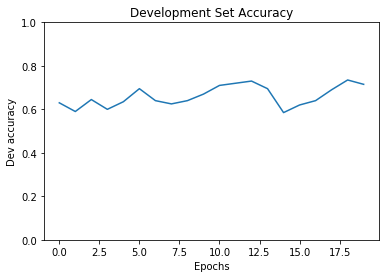

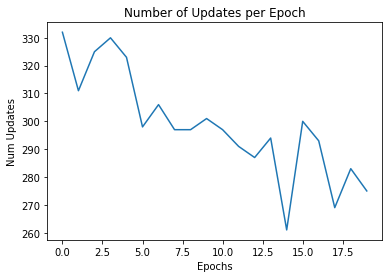

In [6]:
learning_rates = [1.0, 0.1, 0.01]
avg_accuracies = []

# For each learning rate
for rate in learning_rates:
    accuracies = []

    # Calculate accuracy for each fold for 10 epochs
    for i, fold in enumerate(folds_X):
        # Get training folds and validation fold
        training_folds = np.concatenate((np.delete(folds_X, i, axis=0)), axis=0)
        training_folds_y = np.delete(folds_y, i, axis=0).flatten()

        validation_fold = fold
        validation_fold_y = folds_y[i]

        # Use decision tree
        simple_perceptron = Perceptron(rate, seed=seed)
        train_acc = simple_perceptron.train(training_folds, training_folds_y)

        fold_predictions = simple_perceptron.predict(validation_fold)
        fold_correct = (fold_predictions == validation_fold_y).sum()

        accuracies.append(fold_correct/len(fold_predictions))

    avg_accuracies.append(np.array(accuracies).mean())

best_lr_index = int(np.argmax(avg_accuracies))
print('Simple Perceptron:')
print('Best Hyperparameters: learning rate =', learning_rates[best_lr_index])
print('Best cross-validation accuracy for best hyperparameters:', avg_accuracies[best_lr_index])

# Using the best hyper-parameters train classifier for 20 epochs.
# At every epoch measure accuracy on dev set. Use classifier from epoch where the dev
# set accuracy is the highest to evaluate on the test set.

# Use best hyper-parameters
simple_perceptron = Perceptron(learning_rates[best_lr_index], seed=seed)
train_acc, dev_acc, updates_list = simple_perceptron.train(train_X, train_y, epochs=20, dev_x=dev_X, dev_y=dev_y, updates=True)

# Using the best epoch calculate test set accuracy
best_epoch = int(np.argmax(dev_acc)) + 1
print('Total number of updates of training set over twenty epochs training:', sum(updates_list))
print('Development set accuracy:', dev_acc[best_epoch-1])

# Use best epoch and hyper parameters. Seed ensures the same behavior.
simple_perceptron = Perceptron(learning_rates[best_lr_index], seed=seed)
simple_perceptron.train(train_X, train_y, epochs=best_epoch)

pred_test = simple_perceptron.predict(test_X)
test_correct = (pred_test == test_y).sum()
test_acc = test_correct/len(test_y)
print('Test set accuracy:', test_acc)

# Compare dev acc and epoch
plt.title('Development Set Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Dev accuracy')
plt.ylim([0.0, 1.0])
plt.plot(list(range(20)), dev_acc)
plt.show()

plt.title('Number of Updates per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Num Updates')
plt.plot(list(range(20)), updates_list)
plt.show()

# 2. Decaying the learning rate


Perceptron with Learning Rate Decay:
Best Hyperparameters: learning rate = 0.1
Cross-validation accuracy for best hyperparameters: 0.6506666666666667
Total number of updates of training set over twenty epochs: 5491
Development set accuracy: 0.7
Test set accuracy: 0.746268656716418


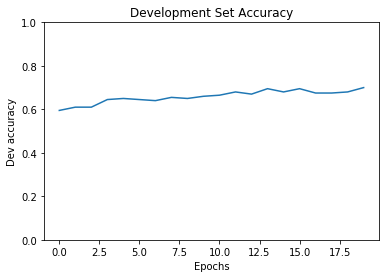

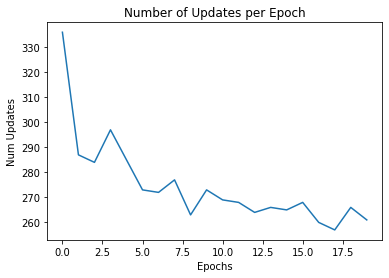

In [7]:
learning_rates = [1.0, 0.1, 0.01]
avg_accuracies = []

# For each learning rate
for rate in learning_rates:
    accuracies = []
    
    # Calculate accuracy for each fold for 10 epochs
    for i, fold in enumerate(folds_X):
        # Get training folds and validation fold
        training_folds = np.concatenate((np.delete(folds_X, i, axis=0)), axis=0)
        training_folds_y = np.delete(folds_y, i, axis=0).flatten()
        
        validation_fold = fold
        validation_fold_y = folds_y[i]
        
        # Use decision tree
        simple_perceptron_decay = Perceptron(rate, decay_lr=True, seed=seed)
        train_acc = simple_perceptron_decay.train(training_folds, training_folds_y)
        
        fold_predictions = simple_perceptron_decay.predict(validation_fold)
        fold_correct = (fold_predictions == validation_fold_y).sum()
        
        accuracies.append(fold_correct/len(fold_predictions))
        
    avg_accuracies.append(np.array(accuracies).mean())

best_lr_index = int(np.argmax(avg_accuracies))

print('Perceptron with Learning Rate Decay:')
print('Best Hyperparameters: learning rate =', learning_rates[best_lr_index])
print('Cross-validation accuracy for best hyperparameters:', avg_accuracies[best_lr_index])

# Using the best hyper-parameters train classifier for 20 epochs.
# At every epoch measure accuracy on dev set. Use classifier from epoch where the dev
# set accuracy is the highest to evaluate on the test set.

# Use best hyper-parameters
simple_perceptron_decay = Perceptron(learning_rates[best_lr_index], decay_lr=True, seed=seed)
train_acc, dev_acc, updates_list = simple_perceptron_decay.train(train_X, train_y, epochs=20, dev_x=dev_X, dev_y=dev_y, updates=True)

# Using the best epoch calculate test set accuracy
best_epoch = int(np.argmax(dev_acc)) + 1
print('Total number of updates of training set over twenty epochs:', sum(updates_list))
print('Development set accuracy:', dev_acc[best_epoch-1])

# Use best epoch and hyper parameters. Seed ensures the same behavior.
simple_perceptron_decay = Perceptron(learning_rates[best_lr_index], decay_lr=True, seed=seed)
simple_perceptron_decay.train(train_X, train_y, epochs=best_epoch)

pred_test = simple_perceptron_decay.predict(test_X)
test_correct = (pred_test == test_y).sum()
test_acc = test_correct/len(test_y)
print('Test set accuracy:', test_acc)

# Compare dev acc and epoch
plt.title('Development Set Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Dev accuracy')
plt.ylim([0.0, 1.0])
plt.plot(list(range(20)), dev_acc)
plt.show()

plt.title('Number of Updates per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Num Updates')
plt.plot(list(range(20)), updates_list)
plt.show()

# 3. Margin Perceptron
Test learning rate and margin hyperparameters

Margin Perceptron:
Best Hyperparameters: learning rate = 0.01 , and margin = 0.01
Cross-validation accuracy for best hyperparameters: 0.656
Total number of updates of training set over twenty epochs: 5766
Development set accuracy: 0.715
Test set accuracy: 0.7661691542288557


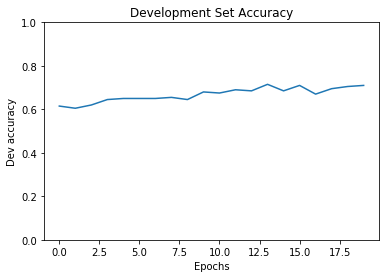

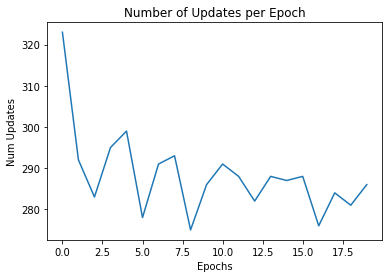

In [8]:
learning_rates = [1.0, 0.1, 0.01]
margins = [1.0, 0.1, 0.01]
avg_accuracies = {}

best_hyper = ()
best_acc = 0

for margin in margins:
    for rate in learning_rates:
        accuracies = []
        
        for i, fold in enumerate(folds_X):
            # Get training folds and validation fold
            training_folds = np.concatenate((np.delete(folds_X, i, axis=0)), axis=0)
            training_folds_y = np.delete(folds_y, i, axis=0).flatten()
            validation_fold = fold
            validation_fold_y = folds_y[i]

            # Use decision tree
            margin_perceptron = Perceptron(rate, decay_lr=True, margin=margin, seed=seed)
            train_acc = margin_perceptron.train(training_folds, training_folds_y)

            fold_predictions = margin_perceptron.predict(validation_fold)
            fold_correct = (fold_predictions == validation_fold_y).sum()

            accuracies.append(fold_correct/len(fold_predictions))

        key = (rate, margin)
        acc = np.mean(accuracies)

        # If this is the best then update
        if acc > best_acc:
            best_acc = acc
            best_hyper = key

        if key in avg_accuracies.keys():
            avg_accuracies[key].append(acc)
        else:
            avg_accuracies[key] = [acc]
         
print('Margin Perceptron:')
print('Best Hyperparameters: learning rate =',  best_hyper[0], ', and margin =', best_hyper[1])
print('Cross-validation accuracy for best hyperparameters:', np.mean(avg_accuracies[best_hyper]))

# Using the best hyper-parameters train classifier for 20 epochs.
# At every epoch measure accuracy on dev set. Use classifier from epoch where the dev
# set accuracy is the highest to evaluate on the test set.

# Use best hyper-parameters
margin_perceptron = Perceptron(best_hyper[0], decay_lr=True, margin=best_hyper[1], seed=seed)
train_acc, dev_acc, updates_list = margin_perceptron.train(train_X, train_y, epochs=20, dev_x=dev_X, dev_y=dev_y, updates=True)

# Using the best epoch calculate test set accuracy
best_epoch = int(np.argmax(dev_acc)) + 1
print('Total number of updates of training set over twenty epochs:', sum(updates_list))
print('Development set accuracy:', dev_acc[best_epoch-1])

# Use best epoch and hyper parameters. Seed ensures the same behavior.
margin_perceptron = Perceptron(best_hyper[0], decay_lr=True, margin=best_hyper[1], seed=seed)
margin_perceptron.train(train_X, train_y, epochs=best_epoch)

pred_test = margin_perceptron.predict(test_X)
test_correct = (pred_test == test_y).sum()
test_acc = test_correct/len(test_y)
print('Test set accuracy:', test_acc)

# Compare dev acc and epoch
plt.title('Development Set Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Dev accuracy')
plt.ylim([0.0, 1.0])
plt.plot(list(range(20)), dev_acc)
plt.show()

plt.title('Number of Updates per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Num Updates')
plt.plot(list(range(20)), updates_list)
plt.show()

# 4. Averaged Perceptron

Averaged Perceptron:
Best Hyperparameters: learning rate = 1.0
Cross-validation accuracy for best hyperparameters: 0.6519999999999999
Total number of updates of training set over twenty epochs: 5970
Development set accuracy: 0.735
Test set accuracy: 0.7114427860696517


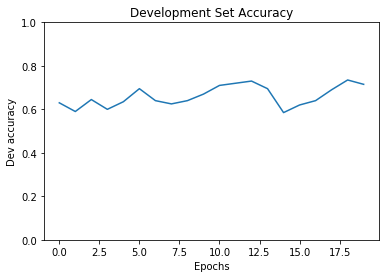

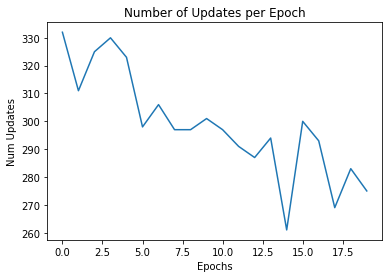

In [9]:
learning_rates = [1.0, 0.1, 0.01]
avg_accuracies = []

for rate in learning_rates:
    accuracies = []
    
    for i,fold in enumerate(folds_X):
        # Get training folds and validation fold
        training_folds = np.concatenate((np.delete(folds_X, i, axis=0)), axis=0)
        training_folds_y = np.delete(folds_y, i, axis=0).flatten()
        validation_fold = folds_X[i]
        validation_fold_y = folds_y[i]
        
        # Use decision tree
        simple_perceptron_avg = Perceptron(rate, average=True, seed=seed)
        train_acc = simple_perceptron_avg.train(training_folds, training_folds_y)
        
        fold_predictions = simple_perceptron_avg.predict(validation_fold)
        fold_correct = (fold_predictions == validation_fold_y).sum()
        
        accuracies.append(fold_correct/len(fold_predictions))
        
    avg_accuracies.append(np.array(accuracies).mean())
    
index = np.argmax(avg_accuracies)

print('Averaged Perceptron:')
print('Best Hyperparameters: learning rate =',  learning_rates[index])
print('Cross-validation accuracy for best hyperparameters:', avg_accuracies[index])

# Using the best hyper-parameters train classifier for 20 epochs.
# At every epoch measure accuracy on dev set. Use classifier from epoch where the dev
# set accuracy is the highest to evaluate on the test set.

# Use best hyper-parameters
simple_perceptron_avg = Perceptron(learning_rates[index], seed=seed)
train_acc, dev_acc, updates_list = simple_perceptron_avg.train(train_X, train_y, epochs=20, dev_x=dev_X, dev_y=dev_y, updates=True)

# Using the best epoch calculate test set accuracy
best_epoch = int(np.argmax(dev_acc)) + 1
print('Total number of updates of training set over twenty epochs:', sum(updates_list))
print('Development set accuracy:', dev_acc[best_epoch-1])

# Use best epoch and hyper parameters. Seed ensures the same behavior.
simple_perceptron_avg = Perceptron(learning_rates[index], average=True, seed=seed)
simple_perceptron_avg.train(train_X, train_y, epochs=best_epoch)

pred_test = simple_perceptron_avg.predict(test_X)
test_correct = (pred_test == test_y).sum()
test_acc = test_correct/len(test_y)
print('Test set accuracy:', test_acc)

# Compare dev acc and epoch
plt.title('Development Set Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Dev accuracy')
plt.ylim([0.0, 1.0])
plt.plot(list(range(20)), dev_acc)
plt.show()

plt.title('Number of Updates per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Num Updates')
plt.plot(list(range(20)), updates_list)
plt.show()

# 5. Aggressive Perceptron with Margin

Aggressive Perceptron:
Best Hyperparameters: learning rate = 1.0 , and margin = 0.01
Cross-validation accuracy for best hyperparameters: 0.6360000000000001
Total number of updates of training set over twenty epochs: 9070
Development set accuracy: 0.73
Test set accuracy: 0.7562189054726368


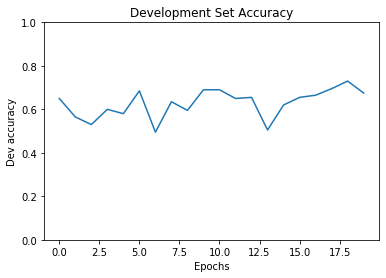

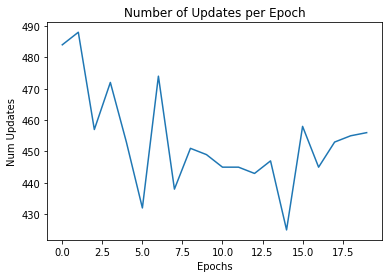

In [10]:
learning_rates = [1.0, 0.1, 0.01]
margins = [1.0, 0.1, 0.01]
avg_accuracies = {}

best_hyper = ()
best_acc = 0

for margin in margins:
    for rate in learning_rates:
        accuracies = []
        
        for i, fold in enumerate(folds_X):
            # Get training folds and validation fold
            training_folds = np.concatenate((np.delete(folds_X, i, axis=0)), axis=0)
            training_folds_y = np.delete(folds_y, i, axis=0).flatten()
            validation_fold = fold
            validation_fold_y = folds_y[i]

            # Use decision tree
            aggressive_perceptron = Perceptron(rate, decay_lr=True, margin=margin, aggresive=True, seed=seed)
            train_acc = aggressive_perceptron.train(training_folds, training_folds_y)

            fold_predictions = aggressive_perceptron.predict(validation_fold)
            fold_correct = (fold_predictions == validation_fold_y).sum()

            accuracies.append(fold_correct/len(fold_predictions))

        key = (rate, margin)
        acc = np.mean(accuracies)

        # If this is the best then update
        if acc > best_acc:
            best_acc = acc
            best_hyper = key

        if key in avg_accuracies.keys():
            avg_accuracies[key].append(acc)
        else:
            avg_accuracies[key] = [acc]
         
print('Aggressive Perceptron:')
print('Best Hyperparameters: learning rate =',  best_hyper[0], ', and margin =', best_hyper[1])
print('Cross-validation accuracy for best hyperparameters:', np.mean(avg_accuracies[best_hyper]))

# Using the best hyper-parameters train classifier for 20 epochs.
# At every epoch measure accuracy on dev set. Use classifier from epoch where the dev
# set accuracy is the highest to evaluate on the test set.

# Use best hyper-parameters
aggressive_perceptron = Perceptron(best_hyper[0], decay_lr=True, margin=best_hyper[1], aggresive=True, seed=seed)
train_acc, dev_acc, updates_list = aggressive_perceptron.train(train_X, train_y, epochs=20, dev_x=dev_X, dev_y=dev_y, updates=True)

# Using the best epoch calculate test set accuracy
best_epoch = int(np.argmax(dev_acc)) + 1
print('Total number of updates of training set over twenty epochs:', sum(updates_list))
print('Development set accuracy:', dev_acc[best_epoch-1])

# Use best epoch and hyper parameters. Seed ensures the same behavior.
aggressive_perceptron = Perceptron(best_hyper[0], decay_lr=True, margin=best_hyper[1], aggresive=True, seed=seed)
aggressive_perceptron.train(train_X, train_y, epochs=best_epoch)

pred_test = aggressive_perceptron.predict(test_X)
test_correct = (pred_test == test_y).sum()
test_acc = test_correct/len(test_y)
print('Test set accuracy:', test_acc)

# Compare dev acc and epoch
plt.title('Development Set Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Dev accuracy')
plt.ylim([0.0, 1.0])
plt.plot(list(range(20)), dev_acc)
plt.show()

plt.title('Number of Updates per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Num Updates')
plt.plot(list(range(20)), updates_list)
plt.show()